In [36]:
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

tweets = pd.read_csv('BrandTweets.csv')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [94]:
tweets['Brand'] = tweets['Brand'].replace(to_replace="Mr.%20Clean",value="Mr. Clean")
tweets['Brand'].value_counts()

coke         2000
Mr. Clean    1258
budweiser     998
ford          591
audi          288
Name: Brand, dtype: int64

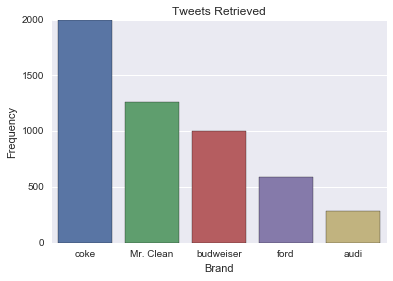

In [95]:
ax = sns.barplot(x=tweets['Brand'].value_counts().index,y=tweets['Brand'].value_counts())
ax.set(xlabel='Brand', ylabel='Frequency')
sns.plt.title('Tweets Retrieved')
plt.show()

In [96]:
def get_freq(tweet,brand_stops):
    '''Takes a tweet and brand stop words and returns a dictionary of tokens and frequencies within tweet.'''
    freq = {}
    
    # Create list of punctuation and "stop words" to remove
    punctuations = list(string.punctuation)
    commercial_stop_words = ['\'s','...','\'\'','``','n\'t','https','rt','commercial','super','bowl','superbowl','via']
    stops = punctuations+commercial_stop_words+brand_stops    
        
    tokens = word_tokenize(tweet)
    
    # Remove stop words and punctuation
    targets = [word.lower() for word in tokens if word.lower() not in stopwords.words('english')]
    targets_punct = [word.lower() for word in targets if word.lower() not in stops] 
    
    for t in targets_punct:
        try:
            freq[t] = freq[t]+1
        except:
            freq[t] = 1            
    return freq

In [97]:
def agg_counts(tweets,retweets,brand_stops):
    '''Takes list of tweets (text), retweets, and list of stop words and aggregates frequencies of all tokens, 
    returned as a dictionary.'''
    # Define frequency dictionary
    all_freq = {}
    
    # Loop through all tweets
    for i in range(0,len(tweets)): 
        tweet = tweets[i]
        tweet = tweet.decode("utf8")
        
        # Get number of retweets of one tweet. Assumes all retweets duplicate rows have already been removed.
        retweet_ct = retweets[i]

        # Get the token frequencies of one tweet
        tweet_freq = get_freq(tweet,brand_stops) 
        
        # Multiply frequencies by number of retweets
        tweet_freq.update((x, y*(retweet_ct+1)) for x, y in tweet_freq.items())

        for key in set(tweet_freq)&set(all_freq):
            all_freq[key] += tweet_freq[key]
        for key in set(tweet_freq).difference(set(all_freq)):
            all_freq[key] = tweet_freq[key]
    
    return all_freq

In [98]:
def get_brand_df(brand):
    '''Based on brand keyword, return a cleaned dataframe for that brand'''
    brand_subset = tweets[tweets['Brand'] == brand]
    
    # Remove duplicate rows for retweets
    brand_subset = brand_subset.drop_duplicates(subset = 'text')
    
    # Create percentage of all retweets column
    brand_subset['retweet_pct'] = 1.0*brand_subset['retweet_count']/sum(brand_subset['retweet_count'])
    
    return brand_subset

### Coca-Cola: "It's Beautiful"
First, consider the Coca-Cola commercial, "It's Beautiful," which originally aired during the 2014 Super Bowl, and again during the 2016 Rio Olympics. The ad features the song "America The Beautiful" being sung in many languages, celebrating diversity and multi-culturalism. We will investigate the main topics of tweets related to the Coca-Cola ad and see if they are similar to the topics intended by the ad.

In [100]:
coke = get_brand_df('coke')

In [101]:
# Get counts as a dictionary
coke_stops = ['coke','cocacola','coca-cola']
coke_tweets = coke['text'].tolist()
coke_RT = coke['retweet_pct'].tolist()
coke_freq_dict = agg_counts(coke_tweets,coke_RT,coke_stops)

# Convert to a dataframe and sort
coke_freq_df = pd.DataFrame.from_dict(coke_freq_dict, orient='index')
coke_freq_df.columns = ['Frequency']
coke_freq_df = coke_freq_df.sort_values('Frequency',ascending=False)

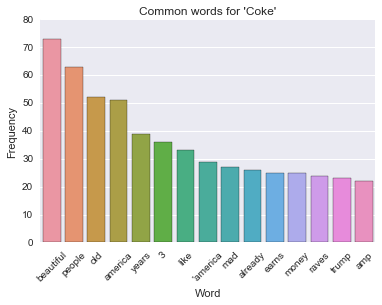

In [102]:
ax = sns.barplot(x=coke_freq_df.index[:15],y=coke_freq_df.ix[:15,'Frequency'])
ax.set(xlabel='Word', ylabel='Frequency')
sns.plt.title('Common words for \'Coke\'')

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.show()

It looks like a lot of people are discussing the content of the ad ("America" and "Beautiful" are very frequent occurences). After that, however, it looks as though Twitter users get distracted by the fact that this is a recycled ad ("3", "years", "old", and "already" could indicate this). Finally, We start seeing some unrealted words like "money" and "Trump". Before analyzing sentiment, we can't be sure how users are feeling about the topics they are discussing.

### Mr. Clean: "Cleaner of Your Dreams"
Next, we consider the Mr. Clean ad, which was designed to be much less serious. The content of this ad was an animated Mr. Clean dancing as he cleaned the house. The idea was to show cleaning as a sexy activity.

In [103]:
mrclean = get_brand_df('Mr. Clean')

In [108]:
# Get counts as a dictionary
clean_stops = ['clean','mr','mr.','mr.clean']
clean_tweets = mrclean['text'].tolist()
clean_RT = mrclean['retweet_pct'].tolist()
clean_freq_dict = agg_counts(clean_tweets,clean_RT,clean_stops)

# Convert to a dataframe and sort
clean_freq_df = pd.DataFrame.from_dict(clean_freq_dict, orient='index')
clean_freq_df.columns = ['Frequency']
clean_freq_df = clean_freq_df.sort_values('Frequency',ascending=False)

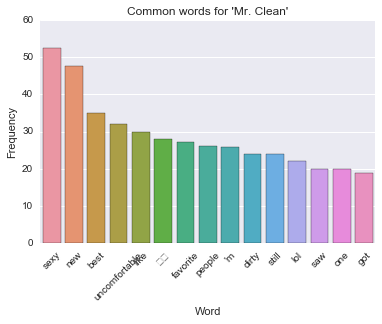

In [109]:
ax = sns.barplot(x=clean_freq_df.index[:15],y=clean_freq_df.ix[:15,'Frequency'])
ax.set(xlabel='Word', ylabel='Frequency')
sns.plt.title('Common words for \'Mr. Clean\'')

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.show()

The rections to the Mr. Clean commercial seem to be relatively on-topic, as the most frequently used word for the commercial was "sexy". Other positively-associated words that make it into the top 15 are "new","best", and "favorite". Although it must be noted that "uncomfortable" is a very frequently used word which would seem to express the opposite sentiment.  The two characters that cannot be decoded could imply that many users needed emoji characters to truly express themselves; words seem to have failed many users during this commercial.

### Budweiser: "Born the Hard Way"
From Budweiser's description of the ad: This is the story of our founder’s ambitious journey to America in pursuit of his dream: to brew the King of Beers.
Adolphus Busch is shown on his journey from Germany and his less-than-friendly reception to St. Louis, Missouri. He is finally accepted by his partner, Eberhard Anheuser. Reviews of the ad note that it is timely due to the current political climate in the US, and the reception of the ad has been divided.

In [110]:
budweiser = get_brand_df('budweiser')

In [114]:
# Get counts as a dictionary
bud_stops = ['budweiser']
bud_tweets = budweiser['text'].tolist()
bud_RT = budweiser['retweet_pct'].tolist()
bud_freq_dict = agg_counts(bud_tweets,bud_RT,bud_stops)

# Convert to a dataframe and sort
bud_freq_df = pd.DataFrame.from_dict(bud_freq_dict, orient='index')
bud_freq_df.columns = ['Frequency']
bud_freq_df = bud_freq_df.sort_values('Frequency',ascending=False)

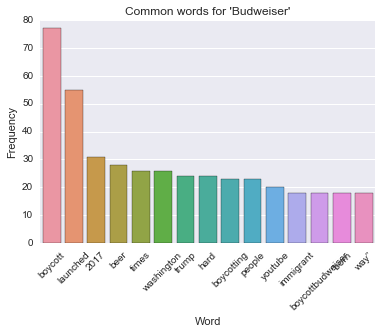

In [115]:
ax = sns.barplot(x=bud_freq_df.index[:15],y=bud_freq_df.ix[:15,'Frequency'])
ax.set(xlabel='Word', ylabel='Frequency')
sns.plt.title('Common words for \'Budweiser\'')

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.show()

We can see evidence of the controversy before any sentiment analysis; the first most frequent word was "boycott", and the top 15 include other versions of this word and the hashtag "boycottbudweiser." There is some evidence of other tweets remaining consistent to the message, however, as we see the words "hard", "times", and "immigrant." 